# Erstellung eines ARIMA-Modells
1. [Dickey-Fuller-Test](#1)
1. [Time Series Split](#2)
1. [AutoARIMA-Modell](#3)
1. [Exponential Smoothing](#4)
1. [Grafische Darstellung](#5)

In [1]:
!pip install darts

  Obtaining dependency information for darts from https://files.pythonhosted.org/packages/89/29/d5d086caa378240deb5d5e90982c772a8c4367e8688fb80754598ee35d14/darts-0.27.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 2.1 MB/s eta 0:00:00
  Obtaining dependency information for pmdarima>=1.8.0 from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for statsforecast>=1.4 from https://files.pythonhosted.org/packages/d0/55/7ae7ac6c564cd1a27311b10eafdc82c99553f16a0aac39d946a6038186aa/statsforecast-1.7.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.6 MB/s eta 0:00:00
  Obtaining dependency information

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from darts import TimeSeries
from statsmodels.tsa.stattools import adfuller

plt.style.use('ggplot')

print("Setup complete")

Setup complete


In [3]:
df = pd.read_csv("../input/ps-ds2/ps_ds2.csv")
df.timestamp = pd.to_datetime(df.timestamp)
df_save = df.copy()
df_save.set_index('timestamp', inplace=True)
df = df[['timestamp', 'use']]

df.head()

,timestamp,use
0,2018-01-01 00:00:00,0.58575
1,2018-01-01 01:00:00,0.43750
2,2018-01-01 02:00:00,0.47875
3,2018-01-01 03:00:00,0.52275
4,2018-01-01 04:00:00,0.41825


<a id="1"></a>
## 1. Dickey-Fuller-Test
* https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda
* https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
* https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results

In [4]:
adf_result = adfuller(df.use.dropna())

test_statistic = adf_result[0]
crit_values = adf_result[4]
max_crit_value = max(crit_values.values())

print("Teststatistik: ", test_statistic)
print("Kritische Werte: ", crit_values)
print()

if test_statistic > max_crit_value: # Trend
    print(f"Die Teststatisik ist größer als die kritischen Werte bei 10%: {round(test_statistic, 2)} > {round(max_crit_value, 2)}")
    print("Die Nullhypothese kann nicht abgelehnt werden")
    print("Die Zeitreihe ist nicht stationär")
else: # Kein Trend
    print("Die Teststatistik ist kleiner als die kritischen Werte bei 1%, daher können wir mit 99%iger Sicherheit sagen, dass es sich um eine stationäre Zeitreihe handelt")
    print("Die Zeitreihe ist stationär")

Teststatistik:  -5.878320522991495
Kritische Werte:  {'1%': -3.4311082296069313, '5%': -2.8618750865101124, '10%': -2.566948361609558}

Die Teststatistik ist kleiner als die kritischen Werte bei 1%, daher können wir mit 99%iger Sicherheit sagen, dass es sich um eine stationäre Zeitreihe handelt
Die Zeitreihe ist stationär


<a id="2"></a>
## 2. Time Series Split
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

In [5]:
from matplotlib.patches import Patch
from sklearn.model_selection import TimeSeriesSplit

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm


def plot_cv_indices(df, cv):
    """
    Erstellt eine Visualisierung für die Aufteilung in Trainings- und Testdaten durch den Time Series Split.
    :param df: Ein Dataframe, der eine Spalte 'use' mit realen Messwerten enthält.
    :param cv: Das TimeSeriesSplit-Objekt, das Informationen zu den folds enthält.
    """
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(df.use)):
        indices = np.array([np.nan] * len(df))
        indices[train_idx] = 0
        indices[test_idx] = 1
        ax.scatter(range(len(indices)), [fold + 0.5] * len(indices), c=indices, marker='_', lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
    n_splits = cv.get_n_splits()
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.2]
    )
    
    ax.legend(
        [Patch(color=cmap_cv(0.02)), Patch(color=cmap_cv(0.8))],
        ['Training set', 'Testing set'],
        loc=(1.02, 0.8)
    )
    
    ax.set_title("Time Series Split Visualisierung")

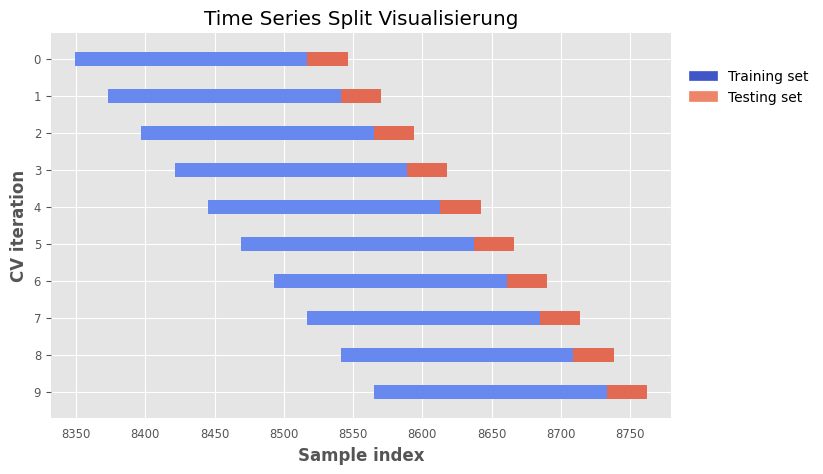

In [6]:
ONE_DAY = 24
ONE_WEEK = ONE_DAY * 7

tscv = TimeSeriesSplit(n_splits=10, max_train_size=ONE_WEEK, test_size=ONE_DAY)

plot_cv_indices(df, tscv)

In [7]:
from darts.metrics import mae, rmse, mape


def calc_metrics(df):
    """
    Berechnet MAE, RMSE und MAPE zwischen den tatsächlichen und vorhergesagten Werten.
    :param df: Ein Dataframe mit zwei Spalten, die die tatsächlichen und vorhergesagten Werte enthalten.
    :return: Eine Liste mit den Werten für MAE, RMSE und MAPE.
    """
    # In darts TimeSeries Objekte konvertieren
    actual = TimeSeries.from_values(df.iloc[:, 0])
    predicted = TimeSeries.from_values(df.iloc[:, 1])
    
    return [
        mae(actual, predicted),
        rmse(actual, predicted),
        mape(actual, predicted)
    ]


def print_avg_metrics(metrics_list):
    """
    Berechnet MAE, RMSE und MAPE als Durchschnitt über alle folds und gibt diese in der Konsole aus.
    :param metrics_list: Eine Liste von Listen, die jeweils die drei Werte für MAE, RMSE und MAPE enthalten.
    """
    sum_mae = sum_rmse = sum_mape = 0.0
    n_folds = len(metrics_list)
    
    for fold in metrics_list:
        sum_mae += fold[0]
        sum_rmse += fold[1]
        sum_mape += fold[2]
    
    avg_mae = sum_mae / n_folds
    avg_rmse = sum_rmse / n_folds
    avg_mape = sum_mape / n_folds
    
    print(f"MAE: {round(avg_mae, 2)}, RMSE: {round(avg_rmse, 2)}, MAPE: {round(avg_mape, 2)} %")

In [8]:
def predict_next_24hours(model, train_series):
    """
    Trainiert ein vorgegebenes Modell mit einer Serie von Trainingsdaten.
    :param model: Ein angepasstes Modell aus der darts Bibliothek.
    :return: Eine Liste mit vorhergesagten Werten für das entsprechende Modell und Trainingsdaten.
    """
    model.fit(train_series)
    preds = model.predict(24)
    return preds.values()


def eval_model(df, cv, model, model_abb):
    """
    Evaluiert ein vorgegebenes Modell für alle folds eines TimeSeriesSplit-Objekts.
    :param df: Ein Dataframe, der einen Zeitstempel und eine Spalte 'use' mit realen Messwerten enthält.
    :param cv: Das TimeSeriesSplit-Objekt, das Informationen zu den folds enthält.
    :param model: Ein angepasstes Modell aus der darts Bibliothek.
    :param model_abb: Ein Abkürzung für das Modell, nach der die Spalte für die vorhergesagten Werte benannt wird.
    :return: Eine Dataframe mit realen und vorhergesagten Werten für das entsprechende Modell.
    """
    metrics_list = list()
    prediction_df = pd.DataFrame()
    
    for train_indices, test_indices in cv.split(df.use):
        train = df[df.index.isin(train_indices)].set_index('timestamp')
        test = df[df.index.isin(test_indices)].set_index('timestamp')
        
        # Imputation
        simple_imputer = SimpleImputer(strategy='median')
        train_data = pd.DataFrame(simple_imputer.fit_transform(train), index=train.index, columns=train.columns)
        test_data = pd.DataFrame(simple_imputer.transform(test), index=test.index, columns=test.columns)
        
        # In darts TimeSeries Objekte konvertieren
        train_series = TimeSeries.from_series(train_data)
        
        temp_df = pd.DataFrame(test_data)
        temp_df.rename(columns={'use': 'actual'}, inplace=True)
        temp_df[f"{model_abb}_preds"] = predict_next_24hours(model, train_series)
        prediction_df = pd.concat([prediction_df, temp_df])
        
        fold_metrics = calc_metrics(temp_df)
        metrics_list.append(fold_metrics)
    
    print_avg_metrics(metrics_list)
    return prediction_df

In [9]:
def full_forecast(df, future_preds_df, model):
    """
    Erstellt eine Vorhersage für Daten aus den Trainingsdaten, für die noch keine Vorhersage getroffen wurde.
    :param df: Ein Dataframe, der einen Zeitstempel und eine Spalte 'use' mit realen Messwerten enthält.
    :param future_preds_df: Ein Dataframe mit den Vorhersagen für die Testdaten für das entsprechende Modell.
    :return: Eine Dataframe mit Zeitstempel und allen Vorhersagen für das entsprechende Modell.
    """
    first_prediction = future_preds_df.index.min()
    future_predictions = future_preds_df.iloc[:, 1]
    data = df[df.timestamp < first_prediction].set_index('timestamp')
    
    # Imputation
    simple_imputer = SimpleImputer(strategy='median')
    imputed_data = pd.DataFrame(simple_imputer.fit_transform(data), index=data.index, columns=data.columns)

    # In darts TimeSeries Objekt konvertieren
    series = TimeSeries.from_series(imputed_data)
    
    historical_forecast = model.historical_forecasts(
        series=series,
        train_length=ONE_WEEK,
        forecast_horizon=ONE_DAY,
        last_points_only=False,
        stride=ONE_DAY,
        verbose=True
    )
    
    temp_df = pd.DataFrame()
    
    for fold in historical_forecast:
        preds = fold.pd_dataframe()
        temp_df = pd.concat([temp_df, preds], axis=0)
    
    new_df = pd.concat([temp_df.use, future_predictions], axis=0)
    return new_df

<a id="3"></a>
## 3. AutoARIMA-Modell
### Setting m: https://alkaline-ml.com/pmdarima/tips_and_tricks.html#setting-m
Blog post: https://robjhyndman.com/hyndsight/seasonal-periods/
1. Saisonalitätsannahme: Der Wert m gibt die Länge der saisonalen Periode an. Bei m=24 geht das Modell davon aus, dass sich das Muster Ihrer Zeitreihe alle 24 Stunden wiederholt. Dies ist typisch für stündliche Daten, bei denen Sie tägliche Muster erwarten, wie z.B. höhere Aktivität während des Tages und niedrigere Aktivität in der Nacht.
2. Saisonale Differenzierung: Im Kontext von ARIMA-Modellen (und deren Erweiterungen wie SARIMA oder AutoARIMA) bezieht sich die saisonale Differenzierung auf die Anzahl der Differenzierungen, die erforderlich sind, um die saisonale Komponente der Zeitreihe stationär zu machen. Bei m=24 wird AutoARIMA versuchen, saisonale Effekte zu erkennen und zu modellieren, die sich im 24-Stunden-Rhythmus wiederholen.
3. Anwendungsbereiche: Ein solches Modell wäre beispielsweise sinnvoll bei der Analyse von Verkehrsdaten, Energieverbrauch, Webseitenaufrufen oder anderen stündlichen Messungen, bei denen tägliche Schwankungen eine Rolle spielen.
4. Modellierungskomplexität: Die Einbeziehung einer täglichen Saisonalität (m=24) in stündlichen Daten kann die Komplexität des Modells erhöhen. Es ist wichtig, die Modellpassung und -vorhersagen sorgfältig zu überprüfen, um sicherzustellen, dass das Modell die saisonalen Muster angemessen erfasst und nicht über- oder unterangepasst ist.

In [10]:
from darts.models import AutoARIMA

auto_arima_model = AutoARIMA(stationary=True, trend=None, seasonal=True)
arima_df = eval_model(df, tscv, auto_arima_model, "arima")

MAE: 0.56, RMSE: 0.84, MAPE: 82.22 %


In [11]:
df_save['arima_preds'] = full_forecast(df, arima_df, auto_arima_model)

  0%|          | 0/348 [00:00<?, ?it/s]

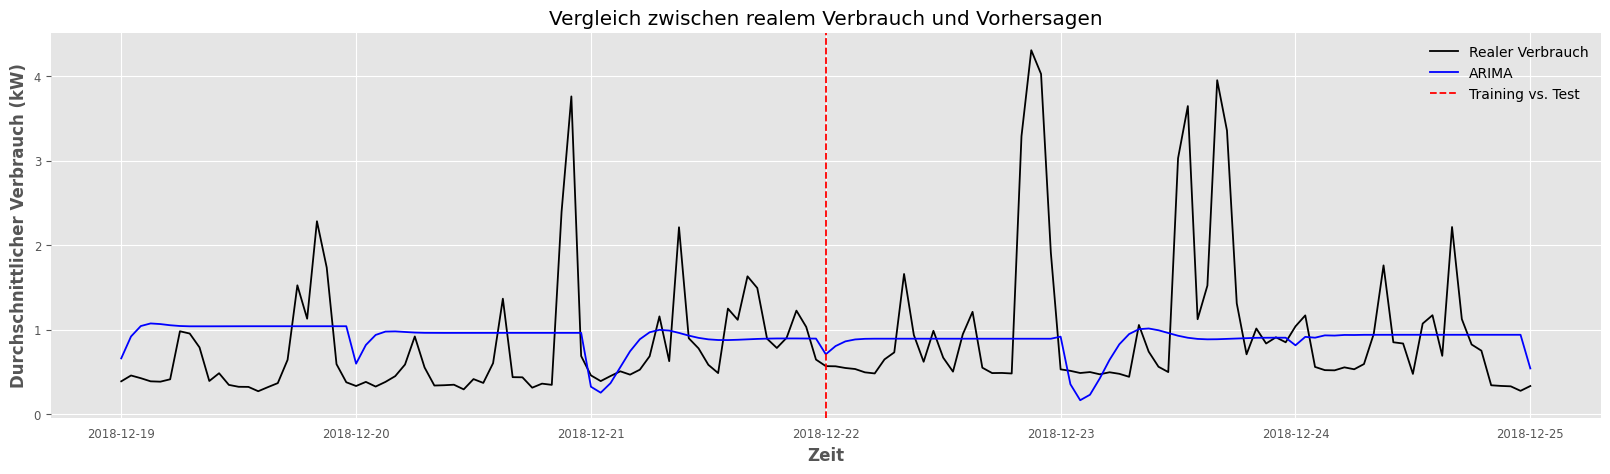

In [12]:
first_prediction = arima_df.index.min()
start_idx = first_prediction - pd.Timedelta(days=3)
end_idx = first_prediction + pd.Timedelta(days=3)
df_comp = df_save[start_idx:end_idx]

plt.figure(figsize=(20, 5))
plt.plot(df_comp.index, df_comp.use, color='black', label='Realer Verbrauch')
plt.plot(df_comp.index, df_comp.arima_preds, color='blue', label='ARIMA')
plt.axvline(x=first_prediction, color='red', linestyle='--', label='Training vs. Test')
plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
plt.xlabel('Zeit')
plt.ylabel('Durchschnittlicher Verbrauch (kW)')
plt.legend()
plt.show()

<a id="4"></a>
## 4. Exponential Smoothing

In [13]:
from darts.models import ExponentialSmoothing

es_model = ExponentialSmoothing(trend=None, seasonal_periods=24)
es_df = eval_model(df, tscv, es_model, "es")

MAE: 0.67, RMSE: 0.94, MAPE: 95.88 %


In [14]:
df_save['es_preds'] = full_forecast(df, es_df, es_model)

  0%|          | 0/348 [00:00<?, ?it/s]

<a id="5"></a>
## 5. Grafische Darstellung

In [15]:
df_plot = pd.DataFrame(arima_df)
df_plot['es_preds'] = es_df.es_preds
df_plot.head()

,actual,arima_preds,es_preds
timestamp,,,
2018-12-22 00:00:00,0.57075,0.710959,0.618068
2018-12-22 01:00:00,0.56875,0.807913,0.354525
2018-12-22 02:00:00,0.54875,0.863376,0.325445
2018-12-22 03:00:00,0.53650,0.886363,0.385541
2018-12-22 04:00:00,0.49725,0.893703,0.366816


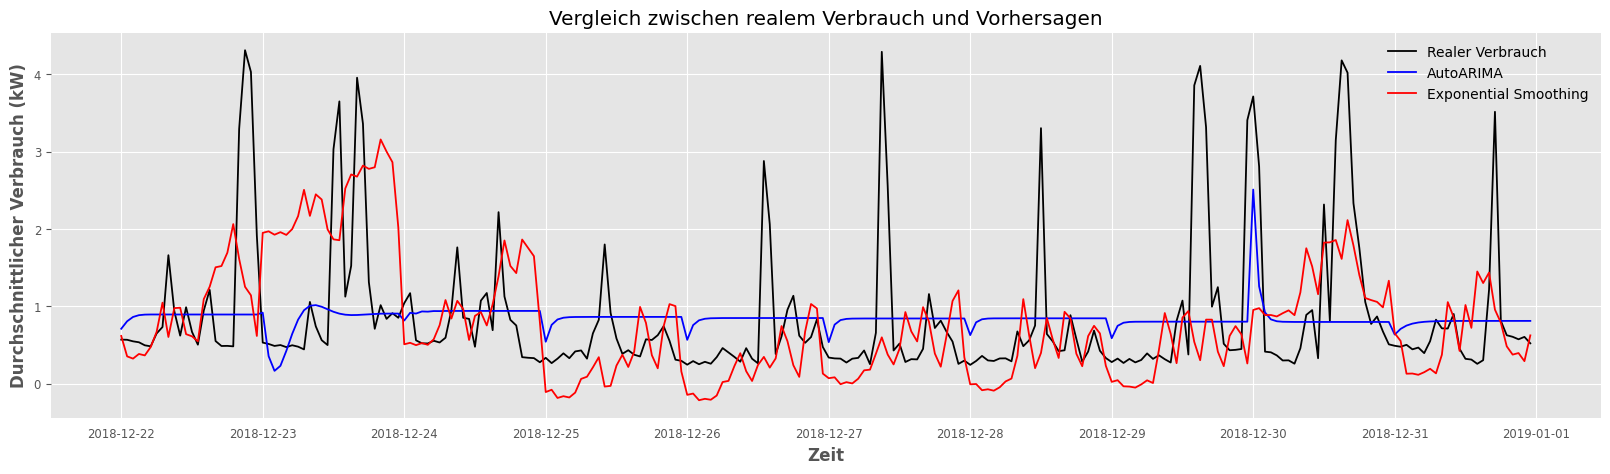

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(df_plot.index, df_plot.actual, color='black', label='Realer Verbrauch')
plt.plot(df_plot.index, df_plot.arima_preds, color='blue', label='AutoARIMA')
plt.plot(df_plot.index, df_plot.es_preds, color='red', label='Exponential Smoothing')
plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
plt.xlabel('Zeit')
plt.ylabel('Durchschnittlicher Verbrauch (kW)')
plt.legend()
plt.show()

In [17]:
# Als csv-Datei speichern
df_save.to_csv('ps_ds3.csv')